# Kaggle's Titanic

In [40]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [45]:
ship = pd.read_csv('train.csv')
ship_test = pd.read_csv('test.csv')

## Data Exploration

In [26]:
ship.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [27]:
ship.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are 891 instances in total.

{Age, Cabin, Embarked} are all missing values and will have to be filled in.

In [28]:
ship.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
ship["Cabin"].describe(), ship["Embarked"].describe()

(count         204
 unique        147
 top       B96 B98
 freq            4
 Name: Cabin, dtype: object,
 count     889
 unique      3
 top         S
 freq      644
 Name: Embarked, dtype: object)

array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

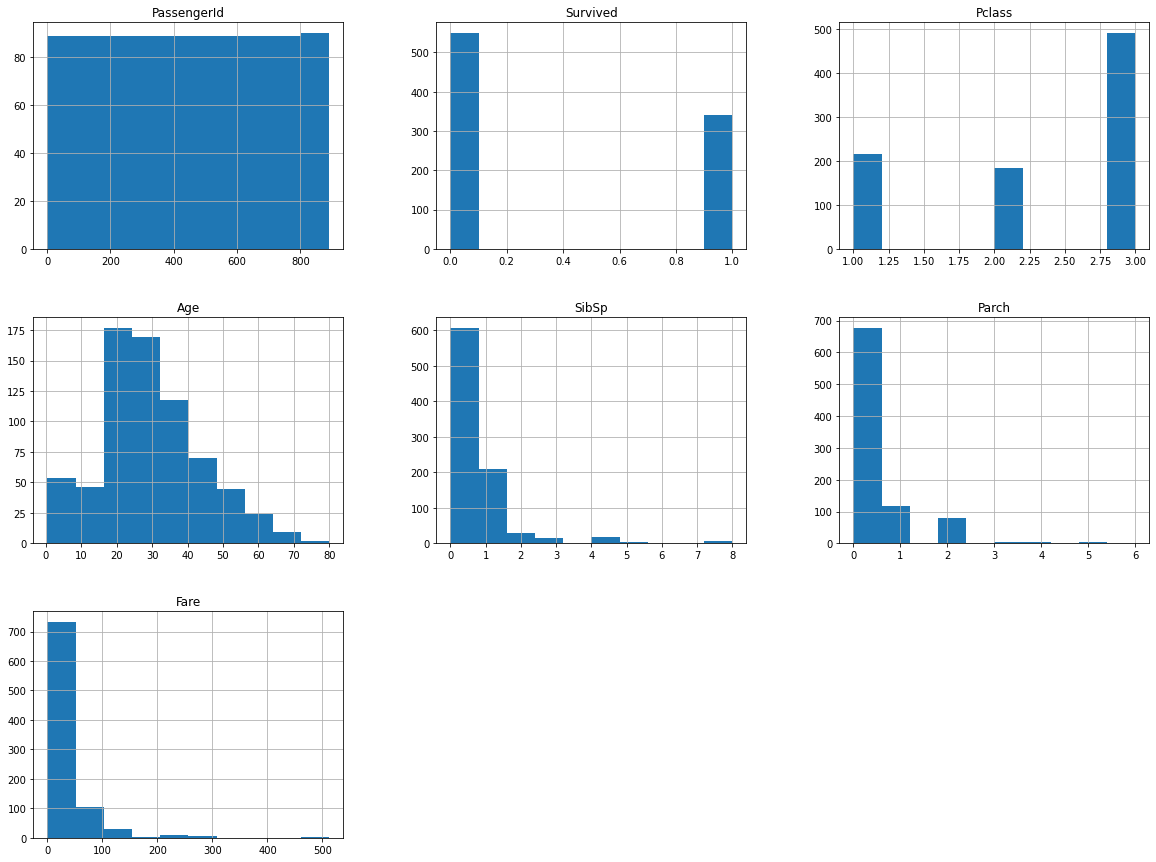

In [7]:
%matplotlib inline
ship.hist(figsize=(20,15))

In [24]:
corr_matrix = ship.corr()
corr_matrix["Survived"]

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

In [46]:
ship.loc[(ship['Survived'] == 1) & (ship['Sex'] == 'female')].count()

PassengerId    233
Survived       233
Pclass         233
Name           233
Sex            233
Age            197
SibSp          233
Parch          233
Ticket         233
Fare           233
Cabin           91
Embarked       231
dtype: int64

**Summary**
***
Columns that have no correlation to survival and can be dropped:
- PassengerID: They are just indices
- Name: All unique names
- Ticket: All unique ticket ID numbers
- Cabin: All unique cabin ID number and 77% missing values

Age missing values to be filled in with `median=28`  
Embarked missing values to be filled in with `S`

## Data Cleaning and Preprocessing

In [46]:
X_train = ship.copy()
y_train = X_train.pop("Survived")

X_test = ship_test.copy()

Create full pipeline with following steps:

1. Fill in missing age values with `SimpleImputer`
2. Scale the numerical values with `StandardScaler`
3. Create binary categorical attributes with `OneHotEncoder`
4. `fit_transform` training set
5. `transform` test set

In [47]:
X_train["Family"] = X_train["SibSp"] + X_train["Parch"]
X_test["Family"] = X_test["SibSp"] + X_test["Parch"]

num_attributes = ["Age", "Fare", "Family"]
cat_attributes = ["Pclass", "Sex"]

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('standard_scaling', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("numerical", numerical_pipeline, num_attributes),
    ("categories", OneHotEncoder(), cat_attributes)
])

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

In [48]:
X_train.shape, X_test.shape

((891, 8), (418, 8))

## Selecting and Training a Model

Try `SGDClassifier`.

In [49]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_scores = cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring="accuracy")
sgd_scores.mean()

0.7631912623187496

In [50]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
leg_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5, scoring="accuracy")
leg_reg_score.mean()

0.7912497646098802

In [53]:
linear_svm_clf = LinearSVC(C=10, loss="hinge")
linear_svm_clf.fit(X_train, y_train)
linear_svm_clf_score = cross_val_score(linear_svm_clf, X_train, y_train, cv=5, scoring="accuracy")
linear_svm_clf_score.mean()

0.7878601468834348

In [64]:
poly_svm_clf = SVC(kernel="poly", degree=3, coef0=1, C=10)
poly_svm_clf.fit(X_train, y_train)
poly_svm_clf_score = cross_val_score(poly_svm_clf, X_train, y_train, cv=5, scoring="accuracy")
poly_svm_clf_score.mean()

0.8215617349821104

In [55]:
rbf_svm_clf = SVC(kernel="sigmoid", gamma=0.0001, C=1000)
rbf_svm_clf.fit(X_train, y_train)
rbf_svm_clf_score = cross_val_score(rbf_svm_clf, X_train, y_train, cv=5, scoring="accuracy")
rbf_svm_clf_score.mean()

0.7867365513778168

In [61]:
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X_train, y_train)
tree_clf_score = cross_val_score(tree_clf, X_train, y_train, cv=5, scoring="accuracy")
tree_clf_score.mean()

0.8193019898311469

## Evaluate on Test Set and Submit

In [65]:
test_predictions = tree_clf.predict(X_test)

In [66]:
output = pd.DataFrame({'PassengerId': ship_test.PassengerId, 'Survived': test_predictions})
output.to_csv('Submission.csv', index=False)